# Hyperparameteroptimization

https://github.com/SGpp/SGpp/blob/master/optimization/examples/optimization.py

Steps:
   1. Definition of the data
   2. Definition of the hyperparameter space
   3. Loop over all different combinations of the hyperparamter space
       1. Define the model with the hyperparameters
       2. Optimize model (learning phase)
       3. Evaluate model and store metric with the parameters
 

## 0. Imports & utils

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools

from mpl_toolkits import mplot3d


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import time, sys
from IPython.display import clear_output

import pysgpp


def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

    
def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

## 1. Definition of Data

In [11]:
NORMAL_FILE_PATH = "ecg/normal"
ABNORMAL_FILE_PATH = "ecg/abnormal"

SPLIT_RATIO = 0.8

# Load the .0 and .1 files as integer and with max 75 elements per entry.
normal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(NORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)
abnormal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(ABNORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)

# Pad the with zeroes, so that each entry has 75 data points. Also append the class number at the end (0=normal, 1=abnormal).
normal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 0) for d in normal_data])
abnormal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 1) for d in abnormal_data])

# Combine the normal and abnormal data and shuffle the whole dataset.
combined_data = np.concatenate((normal_data, abnormal_data))
np.random.shuffle(combined_data)

# Split into training and validation sets.
X_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 0:75])
X_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 0:75])
Y_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 75:])
Y_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 75:])

print("Number of Training samples: ", len(X_train))
print("Number of Testing samples: ", len(X_test))

Number of Training samples:  320
Number of Testing samples:  80


## 2. Definition of Hyperparameter space

Number of hyperparameters:  2


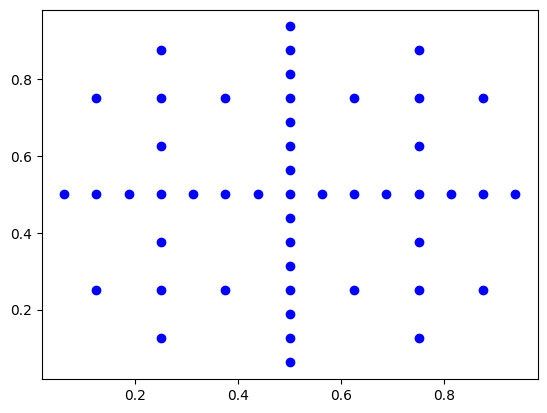

In [12]:
#from interval import Interval



hyperparameters = {
#    "learning_rate" : Interval(0.00001, 0.01),
    "learning_rate" : [0.00001, 0.01],
    "epochs" : [1, 300]
}

print("Number of hyperparameters: ", len(hyperparameters))


grid = pysgpp.Grid.createLinearGrid(len(hyperparameters))

gridStorage = grid.getStorage()
level = 4
grid.getGenerator().regular(level)

x_values = []
y_values = []
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    x_values.append(gp.getStandardCoordinate(0)) 
    y_values.append(gp.getStandardCoordinate(1))
    
    
plt.plot(x_values, y_values, 'bo')

## 3. Loop over combinations

Adaptive grid generation (Ritter-Novak)...
Done in 10897ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
Epochs:  150.5
learning_rate:  0.0037562500000000005
Resulting loss:
-0.8874999999999988
Optimizing (gradient descent)...
[5.36806725143180840654e-01, 1.65243374047589292042e-01]
Done in 0ms.

Optimal hyperparameters after optimization:
Epochs:  50.407768840229195
learning_rate:  0.0053726991841803766
Resulting loss (Optimal value from optimization):
-1.4561289067097092
Resulting loss (Optimal point evaluated):
-0.75


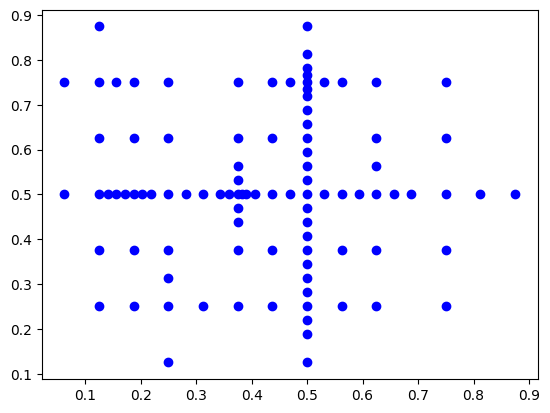

In [16]:
class ExampleFunction(pysgpp.ScalarFunction):
    """Example objective function from the title of my Master's thesis."""

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        # Create neural network with 3 layers (75, 5, 1).
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(75, 15)
                self.fc2 = nn.Linear(15, 1)

            def forward(self, x):
                x = self.fc1(x)
                x = F.relu(x)
                x = self.fc2(x)
                x = torch.sigmoid(x)
                return x

        # Set optimizer and loss function.
        n = Net()
        #optimizer = optim.RMSprop(n.parameters(), lr=0.001)
        
        learning_rate = from_standard(0.00001, 0.01, x[0])
        
        optimizer = optim.RMSprop(n.parameters(), lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        epochs = from_standard(1, 300, x[1])
        t_loss = []
        v_loss = []
        t_acc = []
        v_acc = []


        def avg(l):
            return sum(l) / len(l)

        # Training
        for i in range(int(epochs)):
            n.train()
            y_pred_train = n(X_train)
            loss_train = loss_fn(y_pred_train, Y_train)
            y_pred_test = n(X_test)
            loss_test = loss_fn(y_pred_test, Y_test)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            n.eval()
            t_loss.append(loss_train.item())
            v_loss.append(loss_test.item())
            predictions_test = [round(i[0]) for i in y_pred_test.tolist()]
            accuracy_test = Y_test.tolist()
            acc_test = avg([1 - (abs(predictions_test[i] - accuracy_test[i][0])) for i in
                            range(len(accuracy_test))])
            predictions_train = [round(i[0]) for i in y_pred_train.tolist()]
            accuracy_train = Y_train.tolist()
            acc_train = avg([1 - (abs(predictions_train[i] - accuracy_train[i][0])) for i in
                             range(len(accuracy_train))])
            t_acc.append(acc_train)
            v_acc.append(acc_test)
            
        
        #return min(v_loss)
        return -v_acc[-1]
################################## generate Grid ##################################

pysgpp.omp_set_num_threads(1)

f = ExampleFunction()
# dimension of domain
d = f.getNumberOfParameters()
# B-spline degree
p = 4
# maximal number of grid points
N = 100
# adaptivity of grid generation
gamma = 0.9


grid = pysgpp.Grid.createModBsplineGrid(d, p)
gridGen = pysgpp.OptIterativeGridGeneratorRitterNovak(f, grid, N, gamma)

functionValues = gridGen.getFunctionValues()

if not gridGen.generate():
    print("Grid generation failed, exiting.")
    sys.exit(1)

gridStorage = grid.getStorage()

x_values = []
y_values = []
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    x_values.append(gp.getStandardCoordinate(0)) 
    y_values.append(gp.getStandardCoordinate(1))
    
    
plt.plot(x_values, y_values, 'bo')

######################################## grid functions ########################################
# Hierarchization
functionValues = gridGen.getFunctionValues()
coeffs = pysgpp.DataVector(len(functionValues))
hierSLE = pysgpp.HierarchisationSLE(grid)
sleSolver = pysgpp.AutoSLESolver()

if not sleSolver.solve(hierSLE, gridGen.getFunctionValues(), coeffs):
    print("Solving failed, exiting.")
    sys.exit(1)

# define interpolant and gradient
ft = pysgpp.InterpolantScalarFunction(grid, coeffs)
ftGradient = pysgpp.InterpolantScalarFunctionGradient(grid, coeffs)
gradientDescent = pysgpp.OptGradientDescent(ft, ftGradient)
x0 = pysgpp.DataVector(d)

##################### find point with minimal loss (which are already evaluated) #################

# find point with smallest value as start point for gradient descent
x0Index = 0
fX0 = functionValues[0]
for i in range(1, len(functionValues)):
    if functionValues[i] < fX0:
        fX0 = functionValues[i]
        x0Index = i

x0 = gridStorage.getCoordinates(gridStorage.getPoint(x0Index));
ftX0 = ft.eval(x0)

print("\nOptimal hyperparameters so far:")
print("Epochs: ", from_standard(1,300,x0[1]))
print("learning_rate: ", from_standard(0.00001,0.01,x0[0]))

print("Resulting loss:")
print(ftX0)

################################## Optimize with gradient descent ##################################
#print("x0 = {}".format(x0))
#print("f(x0) = {:.6g}, ft(x0) = {:.6g}\n".format(fX0, ftX0))

## We apply the gradient method and print the results.
gradientDescent.setStartingPoint(x0)
gradientDescent.optimize()
xOpt = gradientDescent.getOptimalPoint()
ftXOpt = gradientDescent.getOptimalValue()

print(xOpt)
fXOpt = f.eval(xOpt)

print("\nOptimal hyperparameters after optimization:")
print("Epochs: ", from_standard(1,300,xOpt[1]))
print("learning_rate: ", from_standard(0.00001,0.01,xOpt[0]))
print("Resulting loss (Optimal value from optimization):")
print(ftXOpt)
print("Resulting loss (Optimal point evaluated):")
print(fXOpt)
#print("\nxOpt = {}".format(xOpt))
#print("f(xOpt) = {:.6g}, ft(xOpt) = {:.6g}\n".format(fXOpt, ftXOpt))